# **SOPORTE: Proceso esquematizado para la realización del reto (Objetivo_1)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U pymgrid

  Using cached pymgrid-1.2.2-py3-none-any.whl
  Attempting uninstall: pymgrid
    Found existing installation: pymgrid 0.1.0
    Uninstalling pymgrid-0.1.0:
      Successfully uninstalled pymgrid-0.1.0


In [3]:
!pip install git+https://github.com/Wenuka/pymgrid/


  Cloning https://github.com/Wenuka/pymgrid/ to /tmp/pip-req-build-zkifxams
  Running command git clone --filter=blob:none --quiet https://github.com/Wenuka/pymgrid/ /tmp/pip-req-build-zkifxams
  Resolved https://github.com/Wenuka/pymgrid/ to commit 6a8091e1ee554c65bdb4bb229570aa94a3bf4a03
  Preparing metadata (setup.py) ... done
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3424050 sha256=91d21f73ed1df099fe6c7c56acda8e65253ce88542e0fd64c6e732625a563e7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9j7emcik/wheels/cd/b4/15/71aa9cbda578c3c22dfcbc0fb165c27772f2099892ca060bd1
Successfully built pymgrid
  Attempting uninstall: pymgrid
    Found existing installation: pymgrid 1.2.2
    Uninstalling pymgrid-1.2.2:
      Successfully uninstalled pymgrid-1.2.2


In [4]:
import gymnasium as gym

In [5]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
!python --version

Python 3.11.11


Nota: Proceso para importar carpeta "data2" en colab

In [6]:
# Selección de archivo (.zip) en Colab a partir de un cuadro de dialogo
from google.colab import files

archivo_subido = files.upload()


Saving data_augmented.zip to data_augmented.zip


In [7]:
# Unzip del fichero seleccionado
import zipfile

with zipfile.ZipFile("data_augmented.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_augmented")  # Extraer en el directorio correcto


In [12]:
env = mg.MicrogridGenerator(nb_microgrid=5, path="./data_augmented/data_augmented/data/pymgrid_data")
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]
mg0.architecture

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

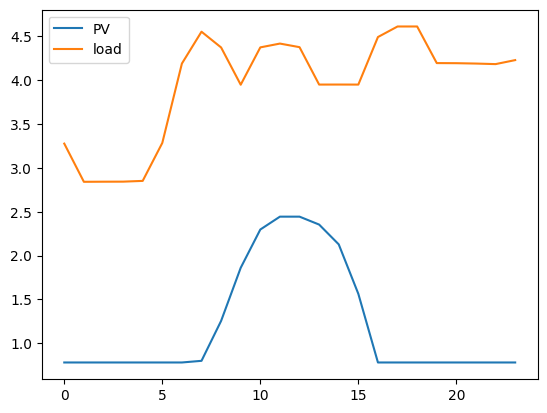

In [13]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()

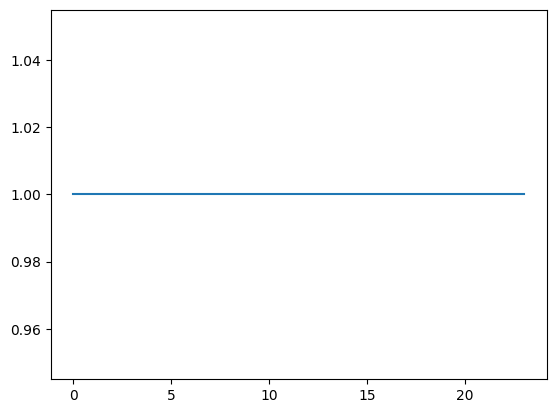

In [14]:
plt.plot(mg0.forecast_grid_status())

**Lo estados podrían ser:**
- Carga (kW)
- FV (kW)
- Bateria (% carga)
- Conexión a red (constante siempre a 1)

Finalmente, podemos definir la carga de red como: carga - FV, así que realmente tenemos **"dos estados"**:

**(Net_load, battery %)**

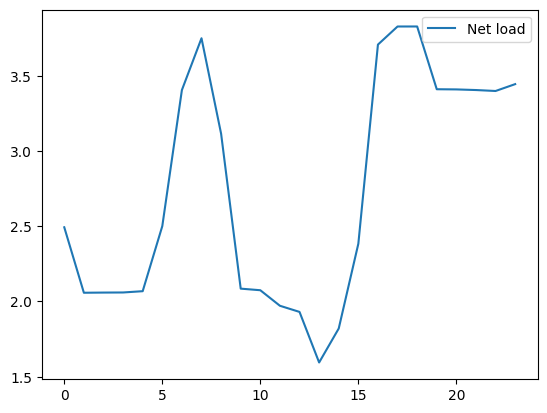

In [15]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

Discretizamos el environment

Current load: 3.2756638303014096
Current PV: 0.7824609166564626
Battery capacity: 21
Battery state of charge: 0.2


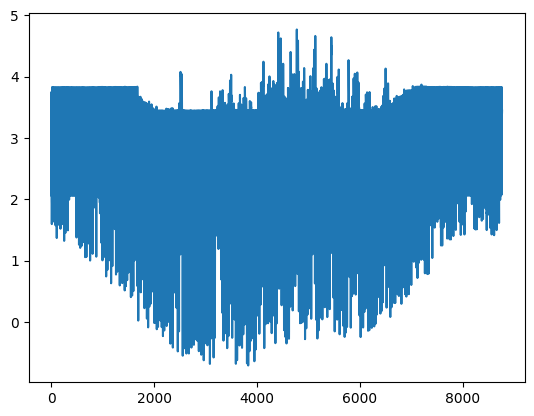

In [16]:
mg0.set_horizon(24*365) # Intervalo de tiempo sobre el cual extraer datos
overall_net_load = mg0.forecast_load()-mg0.forecast_pv()
overal_min = min(overall_net_load)
overal_max = max(overall_net_load)
discretize_interval = 1
net_load_params = (overal_min, overal_max, discretize_interval) # Variable para llamar a función
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")

current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity
battery_state_of_charge = mg0.battery.soc

print(f"Current load: {current_load}")
print(f"Current PV: {current_pv}")
print(f"Battery capacity: {battery_capacity}")
print(f"Battery state of charge: {battery_state_of_charge}")

**Discretizar:** Para aplicarQ-learning definimos estados discretos

**Acciones:**
- Action 0: cargar batería
- Action 1: descargar batería
- Action 2: comprar de la red
- Action 3: vender a la red

**Definimos las acciones, de acuerdo a lo indicado:**

Nota: "La manera o forma de aplicar estas acciones, será explicada en el reto para que no les de a duda de como calcular cada una de ellas.

In [17]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv

    # Calculamos parámetros de la bateria ###
    # Parámetros para la carga:
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # Valor de carga para el periodo de tiempo definido (time stamp) charge value for the time
    # Parámetros para la descarga
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time

    if action == 0:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': p_charge,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':max(0,pv - min(pv,load) - p_charge)
                       }
    elif action ==1:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'grid_import': max(0,load - min(pv,load) - p_discharge),
                        'grid_export':0
                       }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }

    return control_dict

**Inicializamos la Q-table:**

In [18]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [19]:
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
from gymnasium import spaces
import numpy as np
class MicrogridEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, microgrid, horizon=24*7):
        super().__init__()
        self.microgrid = microgrid
        self.horizon = horizon
        self.current_step = 0

        forecast_load = self.microgrid.forecast_load()
        forecast_pv = self.microgrid.forecast_pv()
        net_load = forecast_load - forecast_pv

        self.observation_space = spaces.Box(
            low=np.array([net_load.min(), 0.0], dtype=np.float32),
            high=np.array([net_load.max(), 1.0], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

    def reset(self, seed=None, options=None):
        self.microgrid.reset()
        self.current_step = 0
        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        return np.array([net_load, soc], dtype=np.float32), {}

    def step(self, action):
        control_dict = actions_agent(self.microgrid, action)
        self.microgrid.run(control_dict)

        cost = self.microgrid.get_cost()
        reward = -cost

        self.current_step += 1
        done = self.current_step >= self.horizon

        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        observation = np.array([net_load, soc], dtype=np.float32)

        return observation, reward, done, False, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Load: {self.microgrid.load - self.microgrid.pv}, Battery SOC: {self.microgrid.battery.soc}")

    def close(self):
        pass

In [20]:
from stable_baselines3.common.env_checker import check_env

env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data_augmented/data_augmented/data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env)

check_env(env)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

In [21]:
import os
import pandas as pd
from stable_baselines3.common.monitor import Monitor

os.makedirs("./logs/", exist_ok=True)

env = MicrogridEnv(mg0)
env = Monitor(env, filename="./logs/monitor.csv")

from stable_baselines3.common.env_checker import check_env
check_env(env)

from stable_baselines3 import A2C
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
env.close()
model.save("a2c_microgrid")

log_path = "./logs/monitor.csv"
if os.path.exists(log_path):
    log_df = pd.read_csv(log_path, skiprows=1)
    print(log_df.head())
else:
    print("El archivo de log no se encontró en:", log_path)


Using cpu device
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 168       |
|    ep_rew_mean        | -1.46e+03 |
| time/                 |           |
|    fps                | 315       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.206    |
|    explained_variance | 0.105     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.143    |
|    value_loss         | 14.5      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 168      |
|    ep_rew_mean        | -731     |
| time/                 |          |
|    fps                | 309      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    t

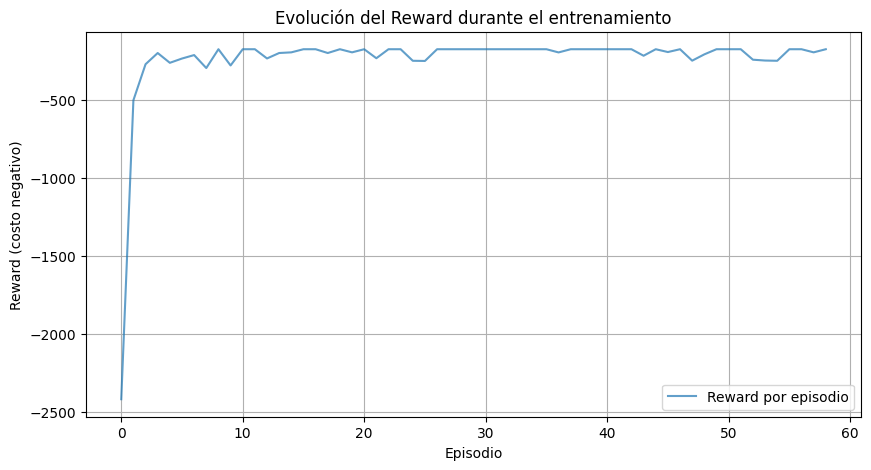

In [22]:
import matplotlib.pyplot as plt

log_df = pd.read_csv("./logs/monitor.csv", skiprows=1)

plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

In [24]:
print(f"Reward final: {log_df['r'].iloc[-1]}")

Reward final: -175.949205


# Q LEARNING

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

def discretize_state(state, bins_net, bins_soc):
    """
    Convierte un estado continuo [net_load, soc] en una tupla discreta (i, j)
    según los bins definidos para cada variable.
    """
    net_load, soc = state
    net_load_bin = np.digitize(net_load, bins_net) - 1
    soc_bin = np.digitize(soc, bins_soc) - 1
    net_load_bin = np.clip(net_load_bin, 0, len(bins_net)-2)
    soc_bin = np.clip(soc_bin, 0, len(bins_soc)-2)
    return (net_load_bin, soc_bin)


In [26]:
env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data_augmented/data_augmented/data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env, filename="./logs/monitor.csv")

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

In [27]:
low_obs = env.observation_space.low
high_obs = env.observation_space.high
bins_net = np.linspace(low_obs[0], high_obs[0], 20)
bins_soc = np.linspace(low_obs[1], high_obs[1], 11)

In [28]:
# Parámetros del Q-Learning
n_episodes = 5000
max_steps = env.unwrapped.horizon
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995

In [29]:
n_actions = env.action_space.n
Q_table = np.zeros((len(bins_net)-1, len(bins_soc)-1, n_actions))

episode_rewards = []

for episode in range(n_episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state, bins_net, bins_soc)
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q_table[state_disc[0], state_disc[1]])

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        next_state_disc = discretize_state(next_state, bins_net, bins_soc)

        best_next = np.max(Q_table[next_state_disc[0], next_state_disc[1]])
        Q_table[state_disc[0], state_disc[1], action] += alpha * (reward + gamma * best_next - Q_table[state_disc[0], state_disc[1], action])

        state_disc = next_state_disc

        if done:
            break

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 100 == 0:
        print(f"Episode: {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")




Episode: 0, Reward: -3537.21, Epsilon: 0.995
Episode: 100, Reward: -2079.61, Epsilon: 0.603
Episode: 200, Reward: -1490.22, Epsilon: 0.365
Episode: 300, Reward: -999.79, Epsilon: 0.221
Episode: 400, Reward: -510.93, Epsilon: 0.134
Episode: 500, Reward: -414.07, Epsilon: 0.100
Episode: 600, Reward: -754.38, Epsilon: 0.100
Episode: 700, Reward: -535.60, Epsilon: 0.100
Episode: 800, Reward: -412.31, Epsilon: 0.100
Episode: 900, Reward: -848.35, Epsilon: 0.100
Episode: 1000, Reward: -494.04, Epsilon: 0.100
Episode: 1100, Reward: -520.06, Epsilon: 0.100
Episode: 1200, Reward: -308.04, Epsilon: 0.100
Episode: 1300, Reward: -426.02, Epsilon: 0.100
Episode: 1400, Reward: -488.38, Epsilon: 0.100
Episode: 1500, Reward: -310.51, Epsilon: 0.100
Episode: 1600, Reward: -670.74, Epsilon: 0.100
Episode: 1700, Reward: -585.68, Epsilon: 0.100
Episode: 1800, Reward: -249.66, Epsilon: 0.100
Episode: 1900, Reward: -448.85, Epsilon: 0.100
Episode: 2000, Reward: -652.01, Epsilon: 0.100
Episode: 2100, Reward:

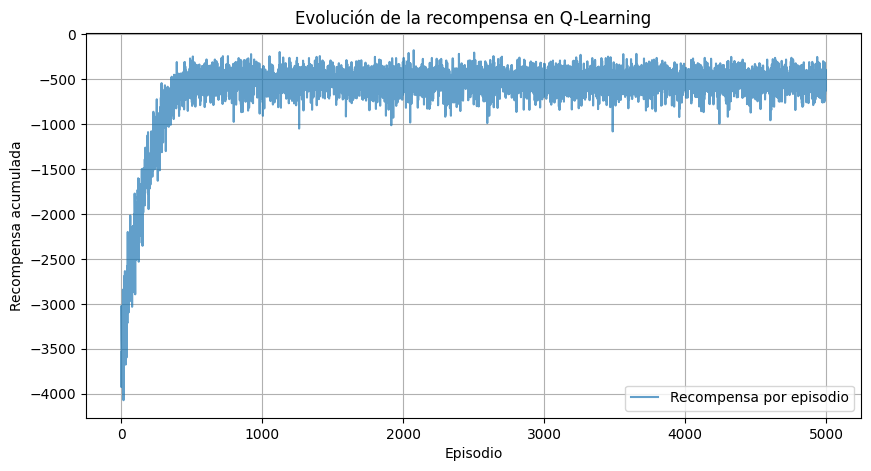

Recompensa promedio en los últimos 100 episodios: -515.99


In [30]:
np.save("qtable_microgrid.npy", Q_table)

plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label="Recompensa por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Recompensa acumulada")
plt.title("Evolución de la recompensa en Q-Learning")
plt.legend()
plt.grid()
plt.show()

last_100_avg = np.mean(episode_rewards[-100:])
print(f"Recompensa promedio en los últimos 100 episodios: {last_100_avg:.2f}")

# PPO

In [32]:
from stable_baselines3 import PPO
import os

env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data_augmented/data_augmented/data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

os.makedirs("./logs/", exist_ok=True)
env_ppo = MicrogridEnv(mg0)
env_ppo = Monitor(env_ppo, filename="./logs/monitor_ppo.csv")
check_env(env_ppo)


os.rename("./logs/monitor_ppo.csv.monitor.csv", "./logs/monitor_ppo.csv")

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

In [33]:
model = PPO("MlpPolicy", env_ppo, verbose=1)
model.learn(total_timesteps=100000)
model.save("ppo_microgrid")
env_ppo.close()

log_df = pd.read_csv("./logs/monitor_ppo.csv", skiprows=1)

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 168       |
|    ep_rew_mean     | -3.62e+03 |
| time/              |           |
|    fps             | 726       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | -3.28e+03   |
| time/                   |             |
|    fps                  | 586         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017082773 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    expla

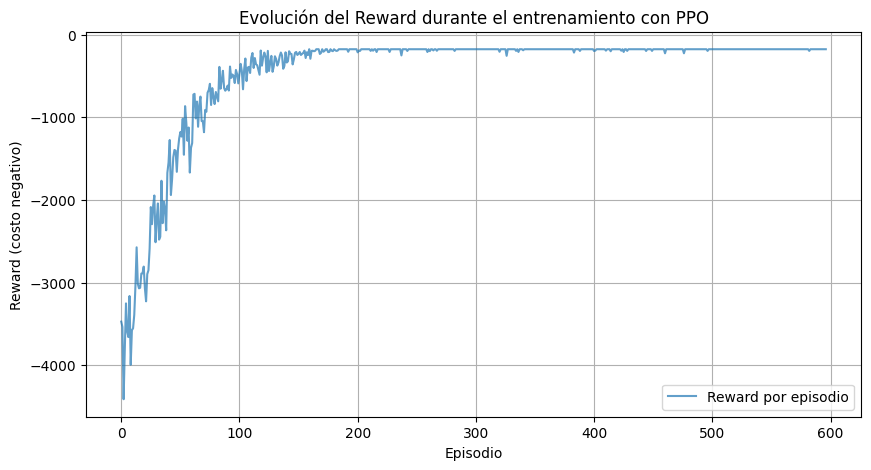

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento con PPO")
plt.legend()
plt.grid()
plt.show()

In [35]:
env = MicrogridEnv(mg0)
env = Monitor(env, filename="./logs/monitor_eval.csv")  # New log file for evaluation

obs, _ = env.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
print("Recompensa total del episodio evaluado con PPO:", total_reward)

# Now, you can close the environment after evaluation
env.close()

Recompensa total del episodio evaluado con PPO: -175.94920520350357


# PPO - OPTUNA

In [36]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.5 MB/s eta 0:00:00


In [37]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
import os
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
def make_env():
    env = MicrogridEnv(mg0)
    env = Monitor(env, filename="./logs/monitor_optuna.csv")
    return env

def objective(trial):
    """Función objetivo para la optimización con Optuna."""

    # Definir el espacio de búsqueda de hiperparámetros
    gamma = trial.suggest_float("gamma", 0.8, 0.9999)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    n_steps = trial.suggest_int("n_steps", 128, 4096, step=128)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512])
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.1)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.5)

    env = make_env()

    model = PPO(
        "MlpPolicy",
        env,
        gamma=gamma,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        ent_coef=ent_coef,
        clip_range=clip_range,
        verbose=0
    )

    model.learn(total_timesteps=50_000)  # Puedes ajustar este número para acelerar la optimización

    # Evaluar el modelo en un episodio
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    env.close()

    return total_reward  # Maximizar la recompensa

In [42]:
# Generar el entorno de la microgrid
env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data_augmented/data_augmented/data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

# Ejecutar la optimización de hiperparámetros con Optuna
study = optuna.create_study(direction="maximize",  storage="sqlite:///microgrid_ppo_v1.db", study_name='microgrid_ppo_v1', load_if_exists=True)
study.optimize(objective, n_trials=20)  # Puedes aumentar el número de pruebas

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:", study.best_params)


/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

Mejores hiperparámetros encontrados: {'gamma': 0.9953201277190202, 'learning_rate': 0.0009534081869453934, 'n_steps': 3328, 'batch_size': 32, 'ent_coef': 0.03240969459900513, 'clip_range': 0.8494442694659744}


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 168       |
|    ep_rew_mean     | -3.61e+03 |
| time/              |           |
|    fps             | 621       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 3328      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 168        |
|    ep_rew_mean          | -2.19e+03  |
| time/                   |            |
|    fps                  | 460        |
|    iterations           | 2          |
|    time_elapsed         | 14         |
|    total_timesteps      | 6656       |
| train/                  |            |
|    approx_kl            | 0.57990134 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.849      |
|    entropy_loss         | -1.04      |
|    explained_variance 

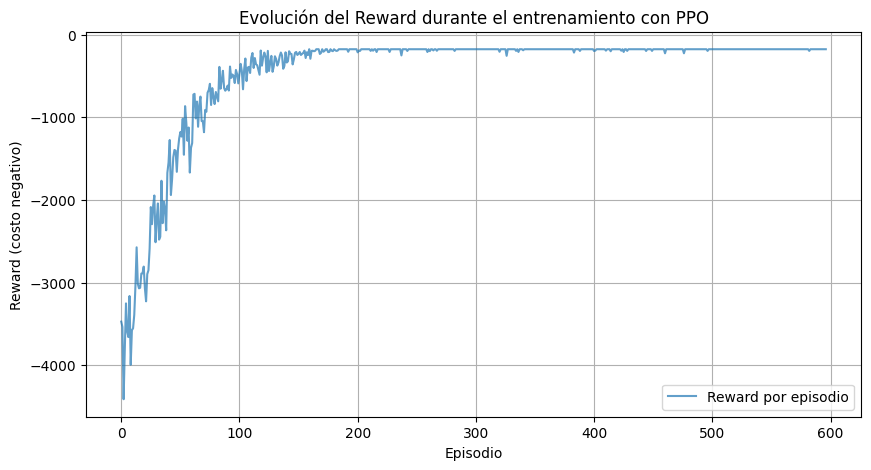

Recompensa total del episodio evaluado con PPO: -190.7618030152231


In [43]:
# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
env_ppo = make_env()

model = PPO(
    "MlpPolicy",
    env_ppo,
    gamma=best_params["gamma"],
    learning_rate=best_params["learning_rate"],
    n_steps=best_params["n_steps"],
    batch_size=best_params["batch_size"],
    ent_coef=best_params["ent_coef"],
    clip_range=best_params["clip_range"],
    verbose=1
)

model.learn(total_timesteps=100_000)
model.save("ppo_microgrid_best")
env_ppo.close()

# Graficar evolución del reward
log_df = pd.read_csv("./logs/monitor_ppo.csv", skiprows=1)

plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento con PPO")
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo entrenado
env_eval = MicrogridEnv(mg0)
env_eval = Monitor(env_eval, filename="./logs/monitor_eval.csv")

obs, _ = env_eval.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env_eval.step(action)
    total_reward += reward

print("Recompensa total del episodio evaluado con PPO:", total_reward)

env_eval.close()